# Data analysis

In the below examples, we are going to have a look at two common data analysis problems. First is fitting a function to a data series, and the second is the Fourier analysis of periodic signals such as sound samples. As usual, let's load some useful modules and functions.

In [1]:
%pylab inline
from scipy.optimize import curve_fit # function used for curve fitting
from numpy.fft import *              # routines for the Fourier analysis
from scipy.signal import spectrogram # function creating a spectrogram

Populating the interactive namespace from numpy and matplotlib


## Fitting a function

![smily](http://oroszl.web.elte.hu/data_smiley.png)

Many times, we have to compare the outcome of an experiment to a theoretical model, or we want to calculate the parameters from a theoretical model such that they correspond to our experiment. The most common method for solving this problem is the so called Ordinary Least Squares (OLS) fitting.

Let's assume, that our experimental data consists of $(x_i,y_i)$ pairs, and we have $N$ number of values, that is,  $i=1\dots N$! We would like to fit an $y=f(x,a,b,c,d,\dots)$ function to this data series. The task is to find the parameters $a,b,c,d,\dots$ such that the function estimates our measured data points the best. This task corresponds to the minimalization of the $$S(a,b,c,d,\dots)=\sum_{i=1}^N (y_i-f(x_i,a,b,c,d,\dots))^2$$ function, that is the sum of the squares of the deviations of the points from the function. In the nexct few examples, we are going to have a look at some examples from Python that use the OLS fitting method.

Let us first generate a data series that we use later for experimenting. This is going to be a noisy sine.

In [2]:
t1 = linspace(0,10,100) # sampling
noise=0.3*randn(len(t1))  # Gaussian noise
x1=1.5*sin(t1+2)+noise     # a noisy sine function
error=2*abs(noise)        # the error of the measurement

Let's visualize it!

<ErrorbarContainer object of 3 artists>

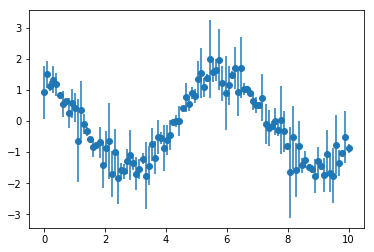

In [3]:
errorbar(t1,x1,error,marker='o',linestyle='')

We are goig to use the `curve_fit` function for the fitting. Its first argument is the function that we would like to fit, let's define it! Let it be of the shape

$$f(t)=A\sin(\omega t+\varphi)!$$

In [4]:
def fun(t,A,omega,phi):
    return A*sin(omega*t+phi)

The function `curve_fit` regards the first argument of the function as the independent variable, and the other arguments as the parameters to fit. It returns two arrays. The first contains the fitted parameters, and the second the so-called covariance matrix. The diagonal emlements of the covariance matrix give the precision of the fitted parameters.

In [5]:
popt,pcov=curve_fit(fun,t1,x1) # fit
perr = sqrt(diag(pcov))      # error
print (['A','omega','phi'])
print (popt)
print (perr)

['A', 'omega', 'phi']
[1.51730126 1.00354584 1.97216152]
[0.04257422 0.00990575 0.05414298]


The first element of the `popt` array is the parameter $A$, the second $\omega$, the third $\varphi$. As we can see, it is a rather optimal fit, because the errors of the fitted parameters are small compared to the estimated parameter values. Because we created an artificial data series by hand, if we compare the fitted values with the parameters that we used for the generation $A=1.5,\,\omega=1.0,\,\varphi=2.0$, we see that we get very close values from the fit. We can evaulate the fitted function after knowing the parameter values.

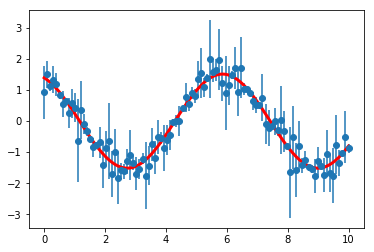

In [6]:
errorbar(t1,x1,error,marker='o',linestyle='') # plotting the data
plot(t1,fun(t1,popt[0],popt[1],popt[2]),color='red',linewidth=3) # plotting the fitted function

We can take into account the measurement errors of the individual points that we stored in the `error` variable. This means that those points that have a big measurement error are going to count less into the curve fit than those with a smaller error. Measurement errors can be given to the `sigma` keyword argument of the `curve_fit` function. Let us observe what happens if we give the errors.

In [7]:
popt_errorval,pcov_errorval=curve_fit(fun,t1,x1,sigma=error)
perr_errorval = sqrt(diag(pcov_errorval))
print (['A','omega','phi'])
print (popt_errorval)
print (perr_errorval)

['A', 'omega', 'phi']
[1.50126118 1.00120434 1.99685898]
[0.0087621  0.00079014 0.00432286]


Is we compare the fit where we took the errors into account, and the fit without the errors, we can see that the fitted parameters slightly differ, but the but the fit error is much less! Let us compare the two curves that we got! We use a more compact notation by [unpacking](https://www.geeksforgeeks.org/packing-and-unpacking-arguments-in-python/) the parameter vector.

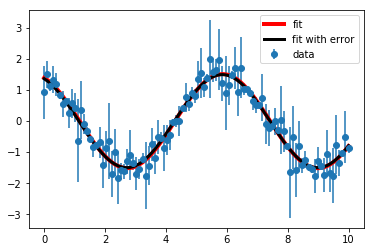

In [8]:
errorbar(t1,x1,error,marker='o',label='data',linestyle='') 
plot(t1,fun(t1,*popt),color='red',label='fit',linewidth=4)  # using unpacking               
plot(t1,fun(t1,*popt_errorval),color='black',label='fit with error',linewidth=3)  # here as well
legend()

The fit algorithms, that work behind the `curve_fit` function, cannot always find the right parameters. If there are too many parameters in a fitting task, this problem might be even more serious. Let us now observe another data series. The datafile `data/ket_gauss_plus_error` contains a noisy data series that is the sum of two Gaussians. Let's try to fit a function to it that is the sum of two Gaussians!

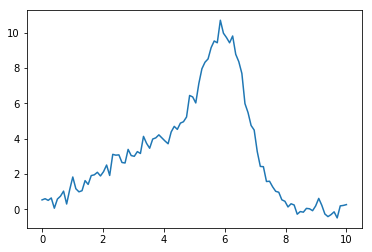

In [9]:
t2,x2=loadtxt('data/ket_gauss_plus_hiba',unpack=True) # reading
plot(t2,x2)                        # plotting

Let's define the function to fit!
$$f_2(t)=A_1\mathrm{e}^{-(t-e_1)^2/s_1^2}+A_2\mathrm{e}^{-(t-e_2)^2/s_2^2}$$

In [10]:
def func2(t,A1,e1,s1,A2,e2,s2):
    'The sum of two Gaussians'
    return A1*exp(-((t-e1)/s1)**2)+A2*exp(-((t-e2)/s2)**2)

Let's try to do the fit!

In [11]:
popt,pcov=curve_fit(func2,t2,x2)
perr = sqrt(diag(pcov))
print (['A1','e1','s1','A2','e2','s2'])
print (popt)
print (perr)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

We did not succeed. This data and the function that we want to determine illustrates the problem really well. 

The fit is more likely to be successful is we can estimate the parameters in advance. In the above data, there is a big peak around 6 that has a width of roughly 1, and a height of 10, and there is a rather broad shoulder left of this peak, that could stem from a wider and lower peak, e.g. at 4 with a with of 3 and a height if 4. Let's plot the original data with these two estimated Gaussians!

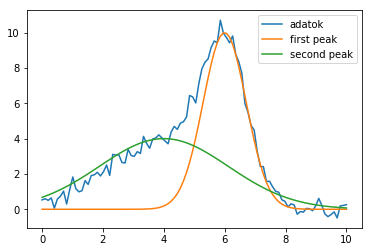

In [12]:
plot(t2,x2,label='adatok') # data
plot(t2,10*exp(-((t2-6)/1)**2),label='first peak') # bigger peak
plot(t2,4*exp(-((t2-4)/3)**2),label='second peak')  # wider peak
legend()

We can give these estimated values to `curve_fit` as the initial values for the fitting procedure through the `p0` keyword argument.

In [13]:
A1=10;e1=6;s1=1
A2=4;e2=4;s2=3
popt,pcov=curve_fit(func2,t2,x2,p0=[A1,e1,s1,A2,e2,s2]) # listing the estimated values in p0
perr = sqrt(diag(pcov))
print (['A1','e1','s1','A2','e2','s2'])
print (popt)
print (perr)

['A1', 'e1', 's1', 'A2', 'e2', 's2']
[8.21260636 5.99414772 1.0291653  3.83303602 3.88151827 2.48802627]
[0.32159323 0.0130322  0.03320234 0.11389945 0.13779395 0.12601698]


The estimation thus helped in completing the fit. Let's plot the fitted function, the original data, and the estimated Gaussians!

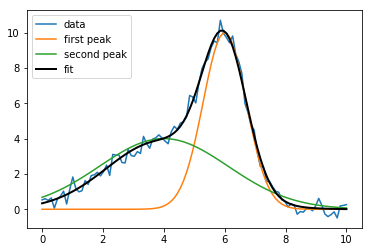

In [14]:
plot(t2,x2,label='data') # data
plot(t2,10*exp(-((t2-6)/1)**2),label='first peak') # a két becsült Gauss
plot(t2,4*exp(-((t2-4)/3)**2),label='second peak')
plot(t2,func2(t2,*popt),label='fit',color='black',linewidth=2) # fitted curve
legend(loc='upper left')

Among the previous examples, we already got to know the data series from the jump of Felix Baumgartner. Let us now examine a real-life fitting example using this data!

In the first phase of the jump, between $t=0\dots 40$ s, the motion is best described by free fall before the parachute opens. After that, drag is going to counter the gravitational force, and the velocity of the fall is going to becomeroughly constant in the interval $t=210\dots 260$ s.

Let us determine $g$ from the points at the beginning of the path, and let us determine the drag force using the last points of the path!

First, we [summarize](http://www.livescience.com/23710-physics-supersonic-skydive.html) the phenomena that we want to model.

**Free fall in the beginning**

Free fall is a constanly accelerated motion , thus, we can write the height as a function of time in the following form
$$h(t)=h_0+v_0t-\frac{g}{2}t^2.$$ The gravitational force can then be determined from the coefficients of the parabole fitted to the beginning of the jump, because the coefficient of the square term corresponds to $g/2$.

**Contant velocity motion in the end**

Because there is no acceleration, the drag force and the gravitational force are equal. Therefore, $$mg=\alpha v^2,$$ that leaves us with the drag being $\alpha=\frac{mg}{v^2}$. The [weight](http://www.livescience.com/23710-physics-supersonic-skydive.html) of Baumgartner is approximately 110 kg including equipment. We can determine $v$ from the fit.

In [15]:
tB,h=loadtxt('data/h_vs_t',unpack=True) # reading data
# first column is time
# second column is height

Let us now define the functions to be fitted, a linear one and a second order polynomial.

In [16]:
def linear(x,a,b):
    'Linear function: a*x+b'
    return a*x+b

def secondorder(x,a,b,c):
    'Second-order polynomial: a*x^2+b*x+c '
    return a*x**2+b*x+c

First we fit a second-order polynomial to the beginning of the data series. We can get the right part of the arrays by slicing them with the usual method.

In [17]:
p_beginning,pcov =curve_fit(secondorder,tB[tB<40],h[tB<40]) # fitting points with t<40
err_beginning = sqrt(diag(pcov))
# fitted parameter values and their error.
print('a=',p_beginning[0],'±',err_beginning[0]) 
print('b=',p_beginning[1],'±',err_beginning[1])
print('c=',p_beginning[2],'±',err_beginning[2])

a= -4.74047528358971 ± 0.028565968374304543
b= 45.23855709648241 ± 1.1603489766186788
c= 38893.934826982724 ± 9.87019931891045


$g$ is twice the fitted $a$ parameter!

In [18]:
g=abs(p_beginning[0]*2)
g

9.48095056717942

Let us now fit the linear segment, too. Again, we slice the arrays based on the time.

In [19]:
p_end,pcov =curve_fit(linear,tB[(tB>210)*(tB<260)],h[(tB>210)*(tB<260)]) # fitting points with t between 210 and 260
err_end = sqrt(diag(pcov))
# fitted parameter values and their error.
print('a=',p_end[0],'±',err_end[0]) 
print('b=',p_end[1],'±',err_end[1])

a= -60.16480247139714 ± 0.14593435419517792
b= 18299.004687233457 ± 34.35533944874054


The velocity now corresponds to the first fitted parameter. We can get $alpha$ from $\alpha=mg/v^2$.

In [20]:
v=p_end[0]
m=110
alpha= m*g/v**2
alpha

0.28811082561386603

Let's make a plot of all our results.

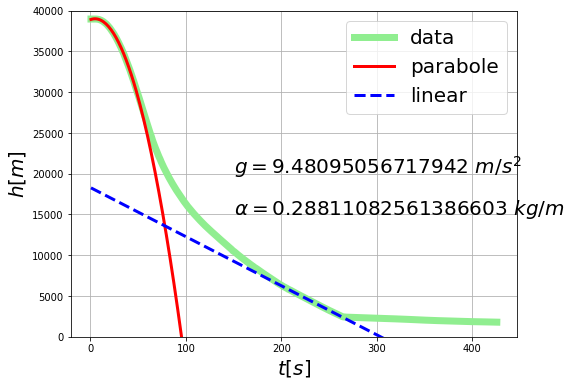

In [21]:
figsize(8,4*3/2)
plot(tB,h,label='data',linewidth=7,color='lightgreen')
plot(tB,secondorder(tB,*p_beginning),label='parabole',linewidth=3,color='red')
plot(tB,linear(tB,*p_end),label='linear',linestyle='dashed',linewidth=3,color='blue')
ylim(0,40000)
legend(fontsize=20)
xlabel(r'$t[s]$',fontsize=20)
ylabel(r'$h[m]$',fontsize=20)
text(150,20000,r'$g=$'+str(g)+r' $m/s^2$',fontsize=20)
text(150,15000,r'$\alpha=$'+str(alpha)+r' $kg/m$',fontsize=20)
grid()

In [22]:
figsize(6,4) #resetting figure size to the default values